# SingleCell Data Analysis on the CPU with Pearson Residuals
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of 500000 brain cells from  [Nvidia](https://github.com/clara-parabricks/rapids-single-cell-examples/blob/master/notebooks/1M_brain_cpu_analysis.ipynb).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time


import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 80, dpi_save = 300)
rcParams['figure.figsize'] = 5,5

sc._settings.ScanpyConfig.n_jobs = 120

## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. 

In [2]:
data_load_start = time.time()

In [3]:
%%time
adata=sc.read("h5/500000.h5ad")
adata.var_names_make_unique()

CPU times: user 547 ms, sys: 4.88 s, total: 5.43 s
Wall time: 15.6 s


In [4]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 15.586982011795044


## Preprocessing

In [5]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

Some genes will now have zero expression in all cells. We filter out such genes.

In [6]:
%%time
adata.var['MT'] = adata.var_names.str.startswith('mt-') 

CPU times: user 4.79 ms, sys: 0 ns, total: 4.79 ms
Wall time: 4.66 ms


In [7]:
%%time
sc.pp.calculate_qc_metrics(adata, qc_vars=['MT'], percent_top=None, log1p=False, inplace=True)

CPU times: user 11.6 s, sys: 518 ms, total: 12.1 s
Wall time: 12.1 s


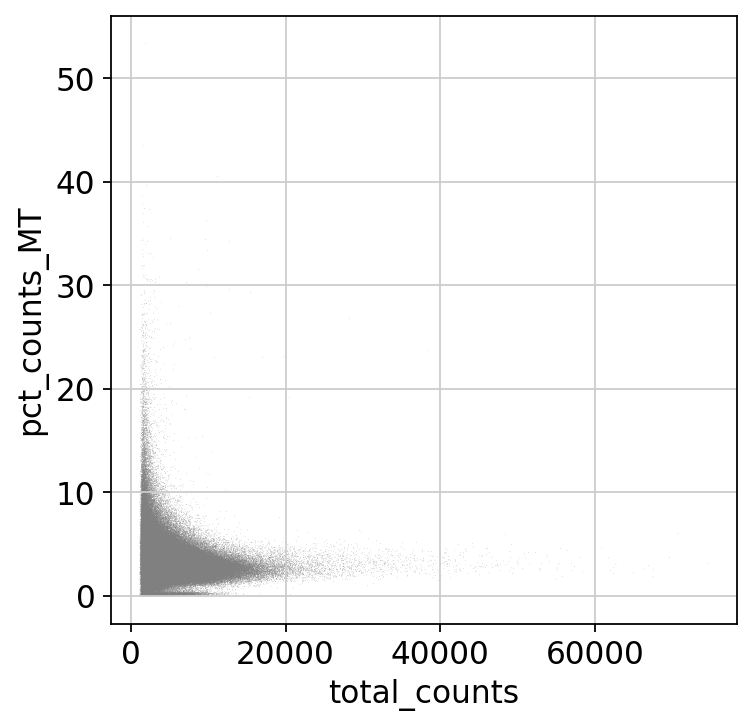

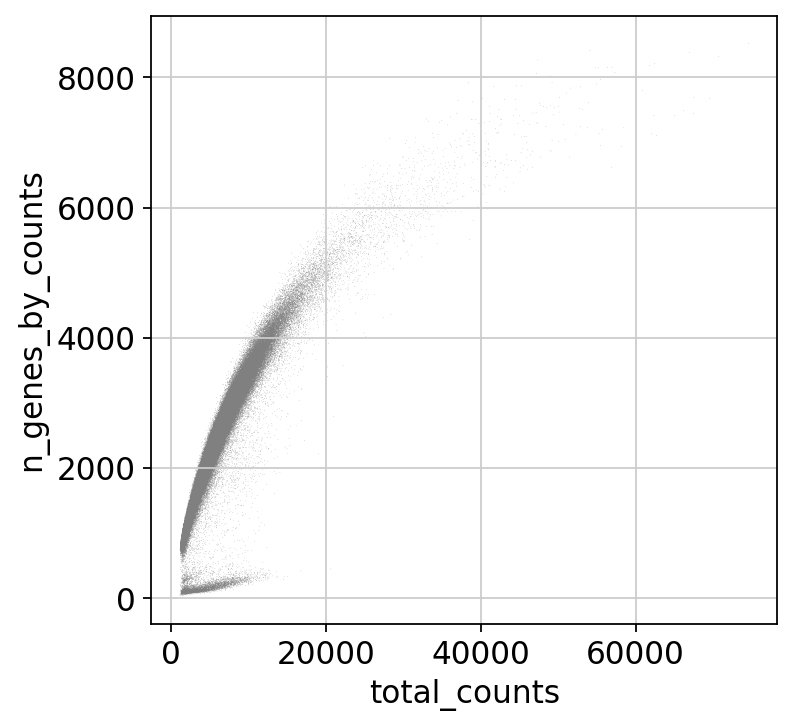

In [8]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_MT')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

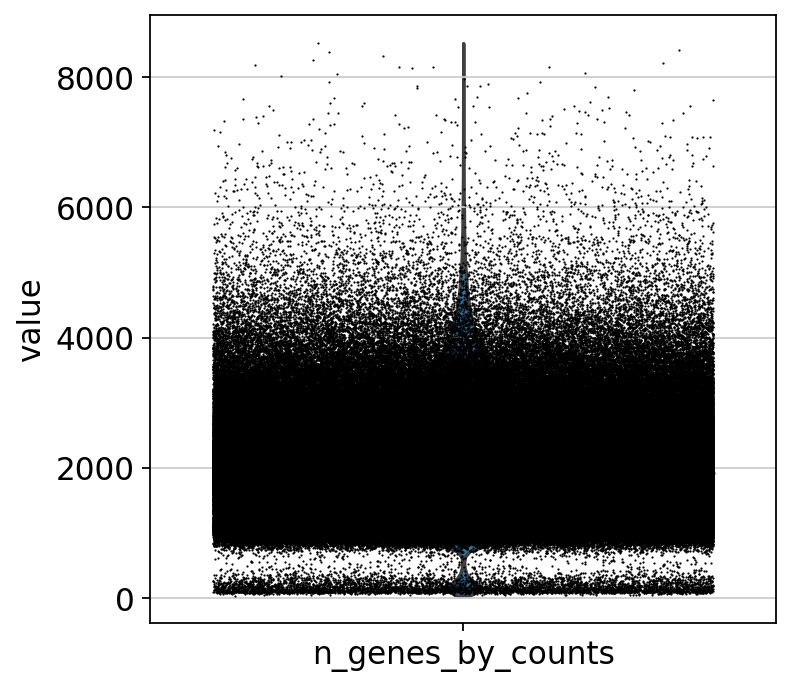

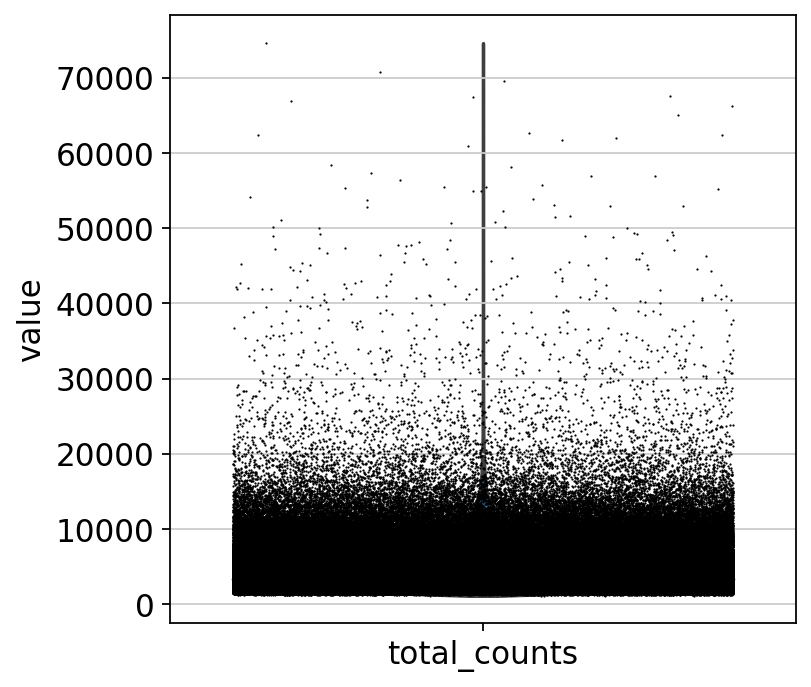

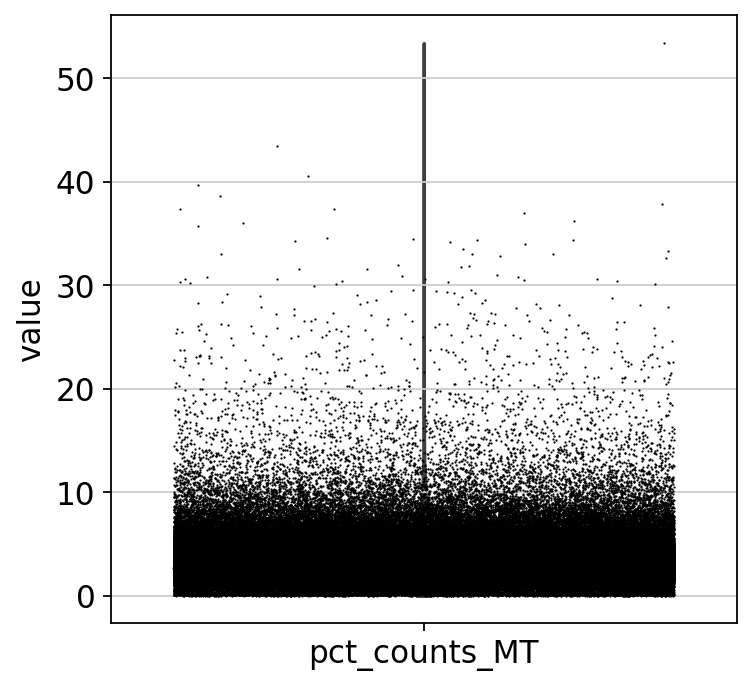

In [9]:
sc.pl.violin(adata, 'n_genes_by_counts',jitter=0.4)
sc.pl.violin(adata, 'total_counts',jitter=0.4)
sc.pl.violin(adata, 'pct_counts_MT',jitter=0.4)


### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.

The size of our count matrix is now reduced.

In [10]:
%%time
sc.pp.filter_genes(adata,min_cells=10)

CPU times: user 23.7 s, sys: 1.87 s, total: 25.5 s
Wall time: 25.6 s


In [11]:
%%time
adata = adata[adata.obs.n_genes_by_counts > 500, :]
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.total_counts < 20000, :]
adata = adata[adata.obs.pct_counts_MT < 20, :].copy()

CPU times: user 889 ms, sys: 1 s, total: 1.89 s
Wall time: 1.9 s


We copy the raw counts to the layer `counts`

In [12]:
adata.layers["counts"] = adata.X.copy()

In [13]:
adata.shape

(483846, 20335)

### Log-Normalize counts

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [14]:
%%time
sc.pp.normalize_total(adata,target_sum=1e4)

CPU times: user 2.66 s, sys: 295 ms, total: 2.95 s
Wall time: 2.96 s


Next, we log transform the count matrix.

In [15]:
%%time
sc.pp.log1p(adata)

CPU times: user 8.07 s, sys: 849 µs, total: 8.07 s
Wall time: 8.1 s


We store this log normalized expression as `.raw`

In [16]:
%%time
adata.raw = adata

CPU times: user 423 ms, sys: 482 ms, total: 904 ms
Wall time: 907 ms


We restore raw counts to `.X`

In [17]:
adata.X = adata.layers["counts"]

### Select Most Variable Genes

We will now select the most variable genes in the dataset based on `pearson_residuals`.

In [18]:
%%time
sc.experimental.pp.highly_variable_genes(adata,flavor="pearson_residuals",n_top_genes=5000)

CPU times: user 1min 14s, sys: 33.4 s, total: 1min 48s
Wall time: 1min 49s


Restrict adata to only the highly variable genes

In [19]:
%%time
adata = adata[:, adata.var.highly_variable].copy()

CPU times: user 9.49 s, sys: 1.43 s, total: 10.9 s
Wall time: 11 s


In [20]:
adata.shape

(483846, 5000)

We will normalize the most variable genes in the dataset based on `pearson_residuals`.

In [21]:
%%time
sc.experimental.pp.normalize_pearson_residuals(adata)

CPU times: user 14 s, sys: 7.74 s, total: 21.7 s
Wall time: 21.8 s


Next we regess out effects of counts per cell and the mitochondrial content of the cells. 

In [22]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 202.83500409126282


## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. 

In [23]:
%%time
sc.tl.pca(adata, n_comps = 150)

CPU times: user 1h 25min 45s, sys: 1h 14min 2s, total: 2h 39min 47s
Wall time: 2min 8s


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

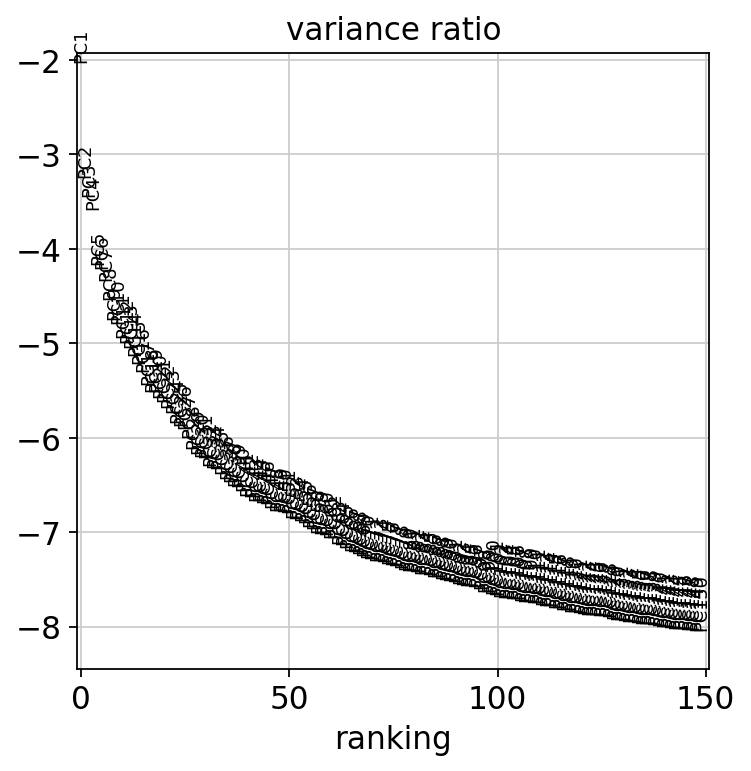

In [24]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=150)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph and UMAP

In [25]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=60)

CPU times: user 7min 17s, sys: 25min 24s, total: 32min 41s
Wall time: 1min 16s


In [26]:
%%time
sc.tl.umap(adata)

CPU times: user 2h 11min 5s, sys: 1h 33min 44s, total: 3h 44min 50s
Wall time: 6min 13s


### Clustering
We cluster the cells with the Leiden and Louvain algorithm

In [27]:
%%time
sc.tl.louvain(adata)

CPU times: user 3min 26s, sys: 1.01 s, total: 3min 27s
Wall time: 3min 27s


In [28]:
%%time
sc.tl.leiden(adata)

IOStream.flush timed out


CPU times: user 10min 8s, sys: 7.53 s, total: 10min 16s
Wall time: 10min 17s


/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


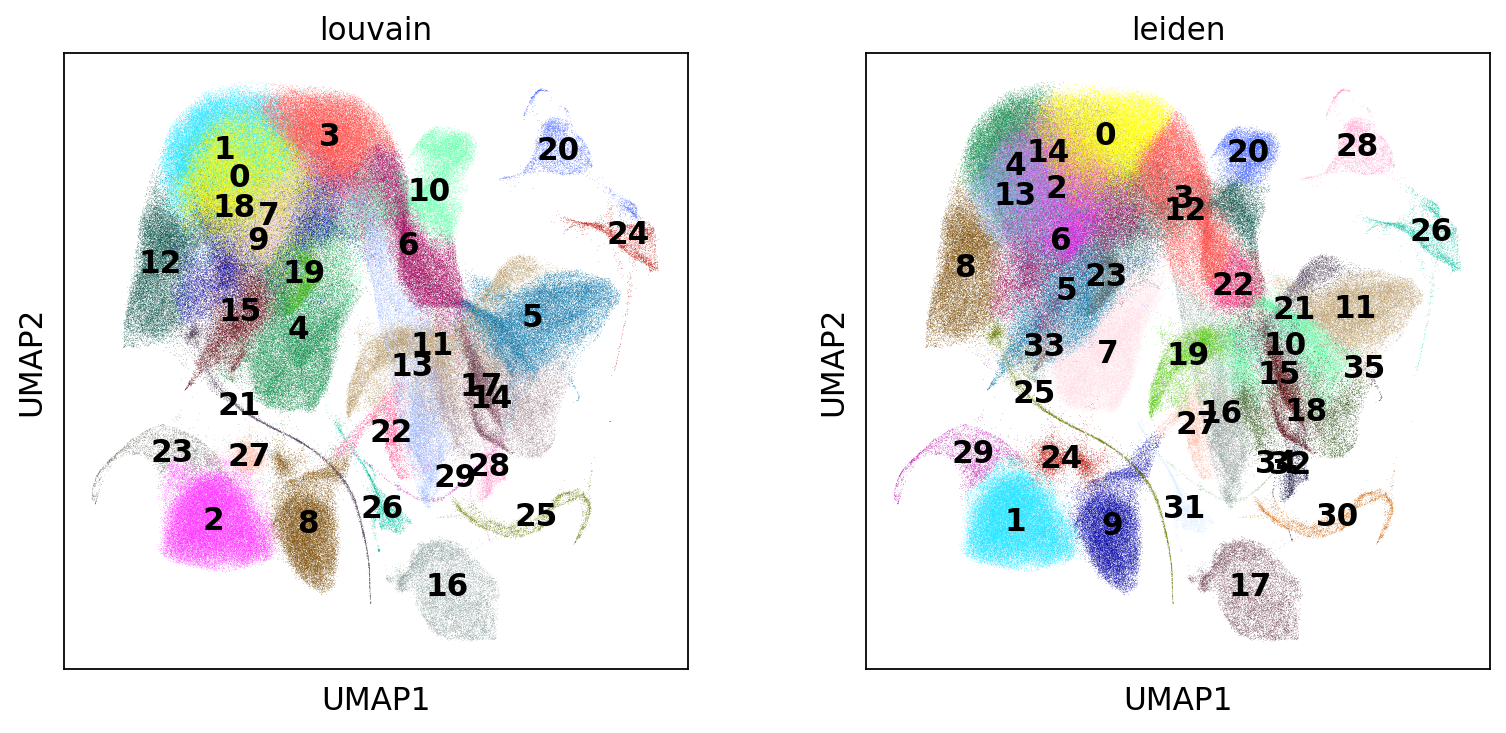

CPU times: user 2.85 s, sys: 176 ms, total: 3.02 s
Wall time: 2.86 s


In [29]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

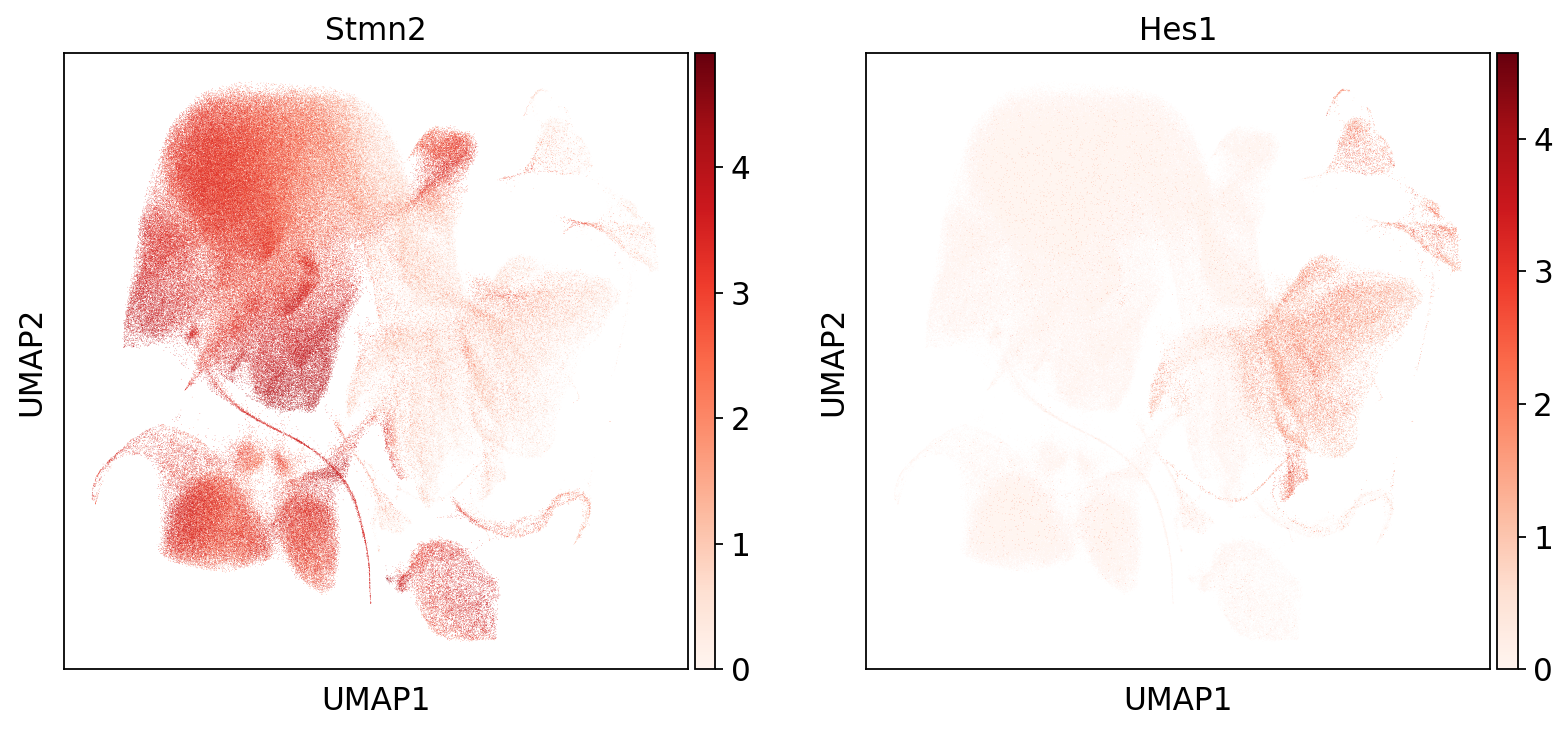

CPU times: user 3.49 s, sys: 170 ms, total: 3.66 s
Wall time: 3.49 s


In [30]:
%%time
sc.pl.umap(adata, color=["Stmn2","Hes1"],legend_loc = 'on data', cmap="Reds")

In [31]:
%%time
sc.tl.diffmap(adata)

CPU times: user 15min 18s, sys: 1h 6min 29s, total: 1h 21min 48s
Wall time: 44.8 s


/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


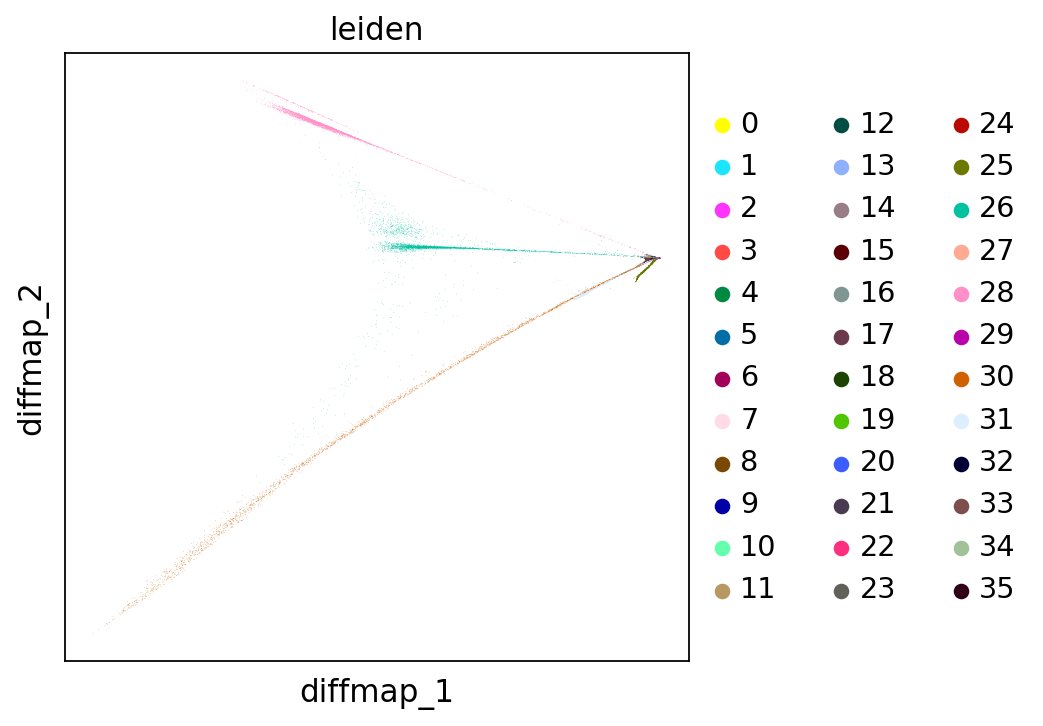

In [36]:
adata.obsm["X_diffmap_"] = adata.obsm["X_diffmap"][:, 1:] 
sc.pl.embedding(adata, "diffmap_", color="leiden")

In [33]:
%%time
sc.tl.rank_genes_groups(adata, 'leiden', method='logreg',layer="counts", use_raw=False)

CPU times: user 22min 27s, sys: 27min 7s, total: 49min 35s
Wall time: 17min 41s


/home/sedi10/conda/envs/rapids-22.12/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


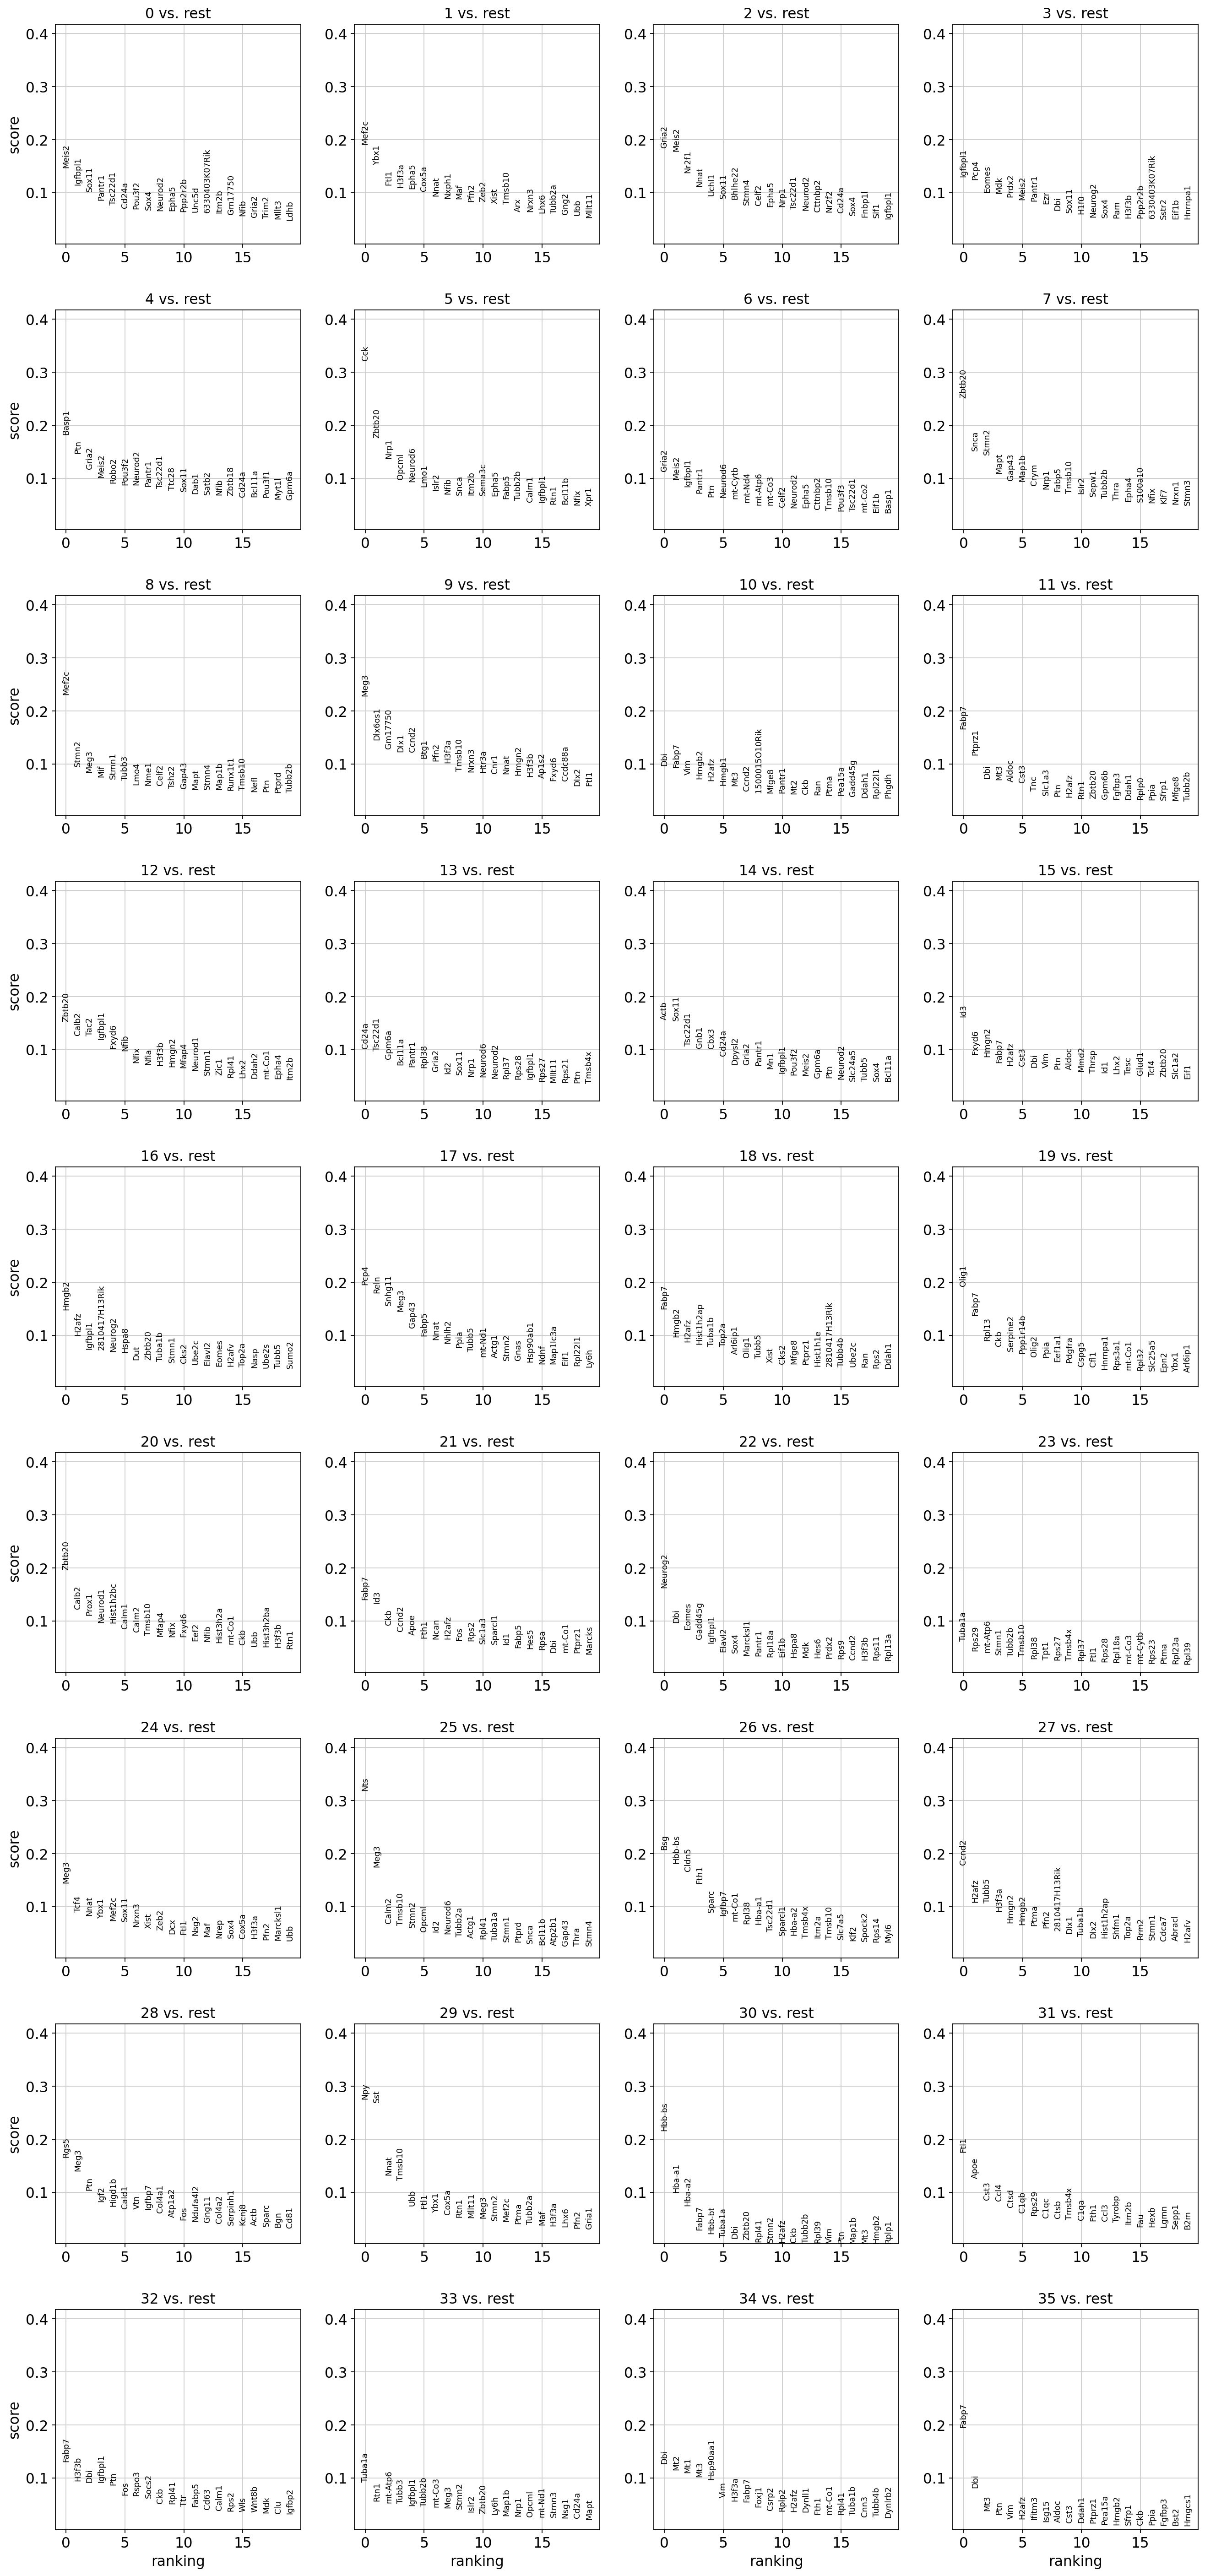

CPU times: user 3.23 s, sys: 334 ms, total: 3.57 s
Wall time: 3.4 s


In [34]:
%%time
sc.pl.rank_genes_groups(adata, n_genes=20)

In [35]:
print("Total Processing time: %s" % (time.time()-preprocess_start))

Total Processing time: 2723.6524856090546
